# Train sklearn models with simple pipeline

In this notebook we train Logistic regression and [Huber classifier](https://en.wikipedia.org/wiki/Huber_loss#Variant_for_classification) from sklearn library and compare their perfomance.

In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

sys.path.append('../..')

from batchflow.models import SklearnModel
from batchflow.opensets import MNIST
from batchflow import B, C, V, D, Pipeline
from examples.utils.utils import plot_images_predictions

Load MNIST dataset.

In [2]:
dataset = MNIST()

Pipeline preprocessing image actions include:
1. Transform images from PIL to np.array.   
2. Reshape them to 2 dimension arrays where the number of rows equal to the batch size.

Sklean models with partial_fit attribute support batch wise training and can be integrated into pipeline.

Initialize both models providing `estimator` in the config with the kwargs for [SGDClassifiers](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.predict_proba)

In [14]:
init_huber_model = Pipeline().init_model('static', SklearnModel, 'my_model', 
                                 config=dict(estimator = SGDClassifier(loss='modified_huber')))
init_logreg_model = Pipeline().init_model('static', SklearnModel, 'my_model', 
                                 config=dict(estimator = SGDClassifier(loss='log')))

Training pipeline template. We exploit the exact same pipeline various times with different estimators.

In [15]:
num_classes = dataset.num_classes
train_template = (dataset.train.p
                    .to_array()
                    .add_namespace(np)
                    .reshape(B('images'), (B('size'), -1), save_to=B('images'))
                    .train_model('my_model', B.images, B.labels, 
                                 classes=list(range(num_classes)))
                    .run_later(64, n_iters=50000, drop_last=True, shuffle=True, bar=True)
           )

Ready to use training pipelines.

In [16]:
huber_train_pipeline = init_huber_model + train_template
logreg_train_pipeline = init_logreg_model + train_template

Run the pipelines.

In [17]:
huber_train_pipeline.run()
logreg_train_pipeline.run()

100%|██████████| 50000/50000 [06:04<00:00, 137.25it/s]


The same steps for test pipelines.   
Instead of initializing models we import them from trained pipelines.

In [18]:
import_huber_model = Pipeline().import_model('my_model', huber_train_pipeline)
import_logreg_model = Pipeline().import_model('my_model', logreg_train_pipeline)

Test pipeline template.

In [19]:
test_template = (dataset.test.p
                    .init_variable('metrics', default=None)
                    .init_variable('predictions')
                    .to_array()
                    .add_namespace(np)
                    .reshape(B('images'), (B('size'), -1), save_to=B('images'))
                    .predict_model('my_model', B('images'), save_to=V('predictions'))              
                    .gather_metrics('class', B.labels, V('predictions'), num_classes=num_classes,
                                    fmt='proba', axis=1, save_to=V('metrics', mode='a'))
                    .run_later(200, n_epochs=1, drop_last=False, shuffle=True, bar=True)
                    .reshape(B('images'), (B('size'), 28, 28), save_to=B('images'))
            )

In [20]:
huber_test_pipeline = import_huber_model + test_template
logreg_test_pipeline = import_logreg_model + test_template

Run test pipelines.

In [21]:
huber_test_pipeline.run()
logreg_test_pipeline.run()

100%|██████████| 50/50 [00:00<00:00, 89.41it/s]


In [22]:
logreg_metrics = logreg_test_pipeline.v('metrics')
huber_metrics = huber_test_pipeline.v('metrics')

In [23]:
logreg_metrics.evaluate('acc'), huber_metrics.evaluate('acc') 

(0.1309, 0.1309)

In [24]:
huber_batch = huber_test_pipeline.next_batch(10, shuffle=True)
logreg_batch = logreg_test_pipeline.next_batch(10, shuffle=True)

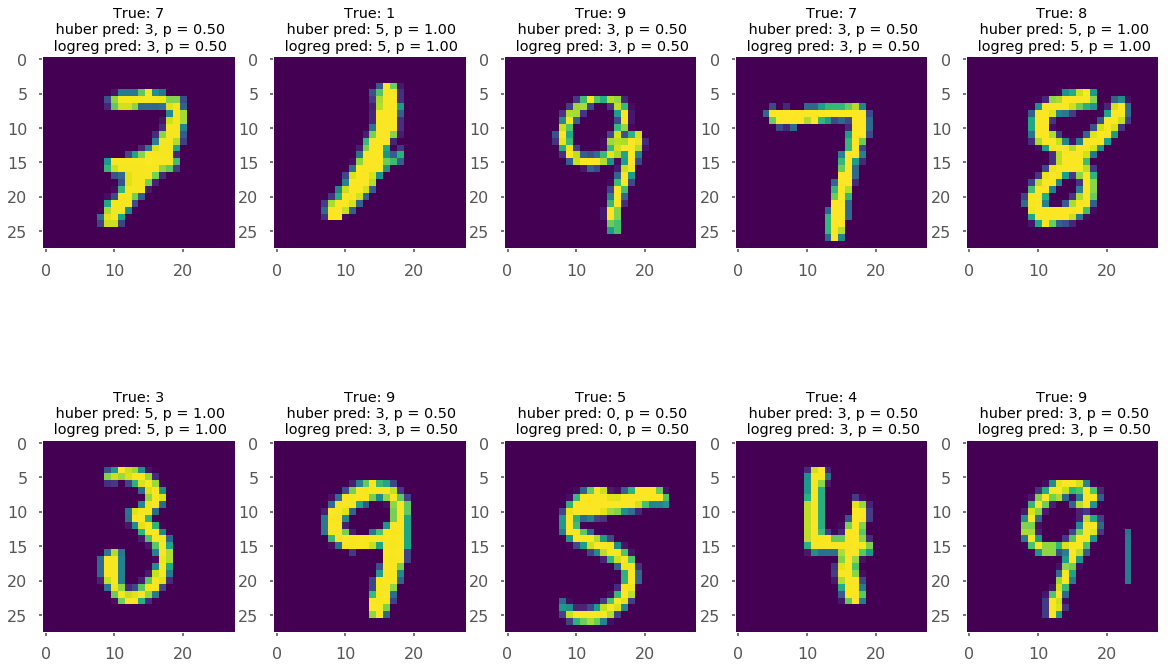

In [25]:
predictions = [huber_batch.pipeline.v('predictions'), logreg_batch.pipeline.v('predictions')]
plot_images_predictions(logreg_batch.images, logreg_batch.labels, predictions,
                        classes_names=None, figsize=(20,20), models_names=['huber', 'logreg'])